In [123]:
%matplotlib widget

import os
import sympy as sm
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as ticker

from matplotlib import pyplot as plt
from mpl_styles import analytic
from scipy.special import hyp2f1
from sympy import init_printing, init_session

plt.style.use(analytic)
init_session()
init_printing()

def Pochhammer(a, k):
    if k == 0:
        return 1.0
    else:
        return (a + k - 1) * Pochhammer(a, k - 1)


def b(s, j, alpha):
    if j >= 0:  # Eq. 7.87
        return (
            2
            * Pochhammer(s, j)
            / Pochhammer(1, j)
            * (alpha**j)
            * hyp2f1(s, s + j, j + 1, alpha * alpha)
        )
    else:  # Eq. 6.69
        return b(s, -j, alpha)


def Db(s, j, alpha):  # Eq. 6.70
    aux = (
        b(s + 1, j - 1, alpha) - 2 * alpha * b(s + 1, j, alpha) + b(s + 1, j + 1, alpha)
    )
    return s * aux


def D2b(s, j, alpha):  # Eq. 6.71
    aux = (
        Db(s + 1, j - 1, alpha)
        - 2 * alpha * Db(s + 1, j, alpha)
        - 2 * b(s + 1, j, alpha)
        + Db(s + 1, j + 1, alpha)
    )
    return s * aux


def f27lc(alpha, j):
    """
    f27 in MD p543
    (1/2)[−2 j − αD] b^(j)_{1/2}(α) x [e1cos(theta1)]
    """
    return 0.5 * (-2 * (j + 1) * b(0.5, j + 1, alpha) - alpha * Db(0.5, j + 1, alpha))


def f31lc(alpha, j):
    """
    f31 in MD p543
    (1/2)[−1 + 2 j + αD] b^(j-1)_{1/2}(α) x [e2cos(theta2)]
    """
    return 0.5 * ((-1 + 2 * (j + 1)) * b(0.5, j, alpha) + alpha * Db(0.5, j, alpha))

alpha0 = (2 / (2 + 1)) ** (2.0 / 3)

############################################################
# If test particle is outside, have to multiply by alpha_0 #
############################################################

f1val_outside = alpha0*f27lc(alpha0, 2)
f2val_outside = alpha0*f31lc(alpha0, 2)

IPython console for SymPy 1.12 (Python 3.12.0-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.12/



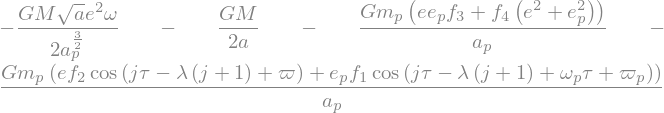

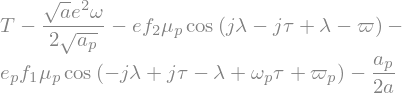

In [133]:
f1, f2, f3, f4, tau, l, pom, pom_p, g, om, om_p, T = sm.symbols(
    "f_1 f_2 f_3 f_4 tau lambda varpi varpi_p gamma omega omega_p T"
)
a, a_p, e, e_p, n, n_p, m_p, mu_p, L, G, Gconst, M, j = sm.symbols(
    "a a_p e e_p n n_p m_p mu_p Lambda Gamma G M j", positive=True
)
X, Y, Te, Tm = sm.symbols("X Y T_e T_m")

H_scale_factor = Gconst * M / a_p
t_scale_factor = sqrt(Gconst * M / a_p**3)  # = n_p
L_scale_factor = H_scale_factor / t_scale_factor

calH = (
    -(Gconst * M) / (2 * a)
    - Gconst
    * m_p
    / a_p
    * (
        e * f2 * sm.cos((j + 1) * l - j * tau - pom)
        + e_p * f1 * sm.cos((j + 1) * l - j * tau - pom_p - om_p * tau)
    )
    - (Gconst * m_p / a_p * (f3 * e * e_p + f4 * (e**2 + e_p**2)))
    - Rational(1, 2) * sqrt(Gconst * M * a) * e**2 * om * t_scale_factor
)


display(calH)
calH = (
    (calH / H_scale_factor)
    .subs(m_p, mu_p * M)
    .simplify()
    .expand()
    .subs({f3: 0, f4: 0})
    #.subs(a, a * a_p)
) + T
display(calH)

In [134]:
def to_canonical(expr):
    return expr.subs({a: L**2, e: sqrt(2 * G / L), pom: -g})


def to_orbelts(expr):
    # This uses the approximation G=1/2*L*e^2
    return expr.subs({g: -pom, G: Rational(1, 2) * L * e**2, L: sqrt(a)})

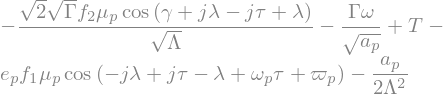

In [135]:
Hcanon = to_canonical(calH)
Hcanon

In [136]:
x = Matrix([tau,l,g,T,L,G])
x

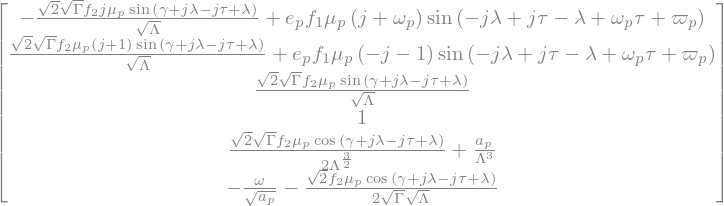

In [137]:
pHpx = Matrix([Hcanon]).jacobian(x).T
pHpx

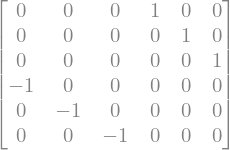

In [138]:
J = Matrix(BlockMatrix([[zeros(3,3),eye(3)],[-eye(3),zeros(3,3)]]))
J

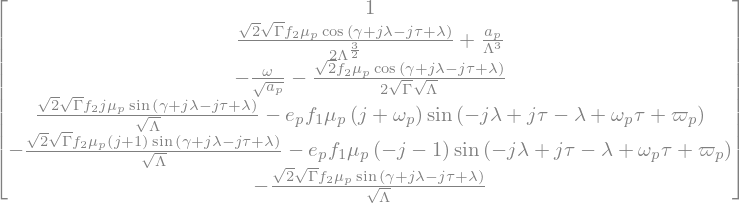

In [139]:
dxdt = J*pHpx
dxdt

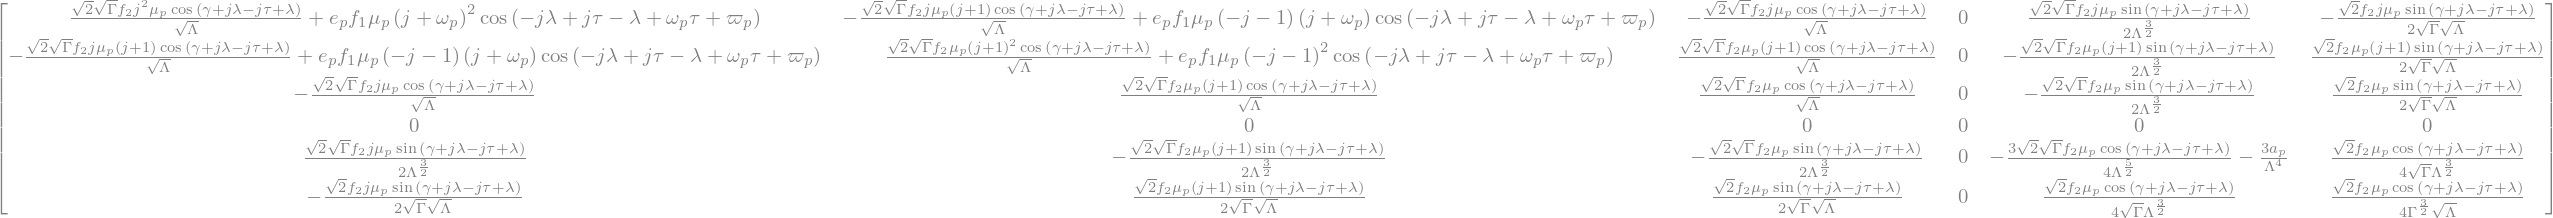

In [140]:
p2Hpx2 = pHpx.jacobian(x)
p2Hpx2

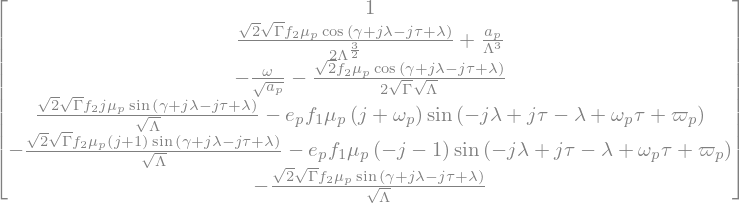

In [141]:
dxdt

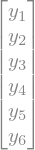

In [143]:
y1, y2, y3, y4, y5, y6 = sm.symbols("y_1 y_2 y_3 y_4 y_5 y_6")
y = Matrix([y1, y2, y3, y4, y5, y6])
y

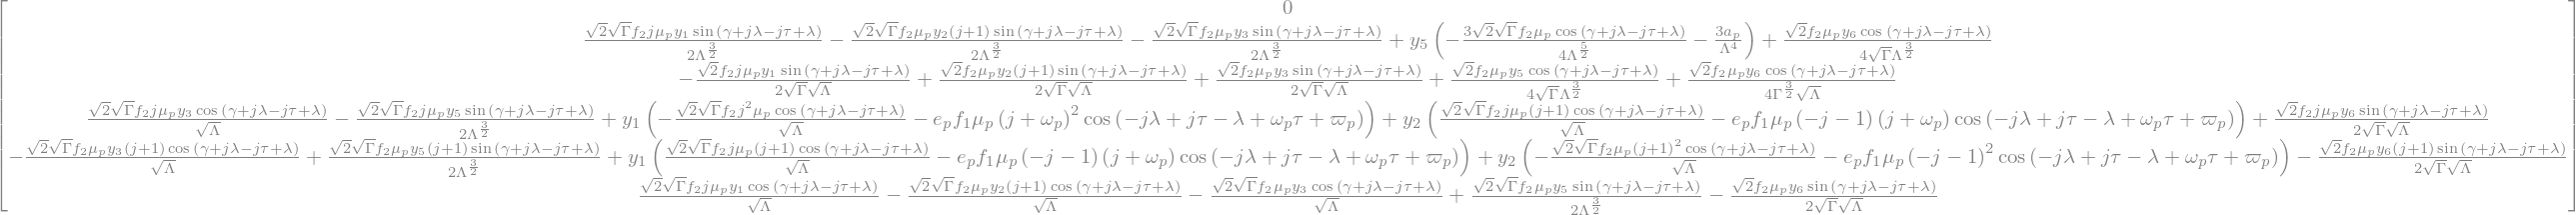

In [144]:
dydt = J*p2Hpx2*y
dydt

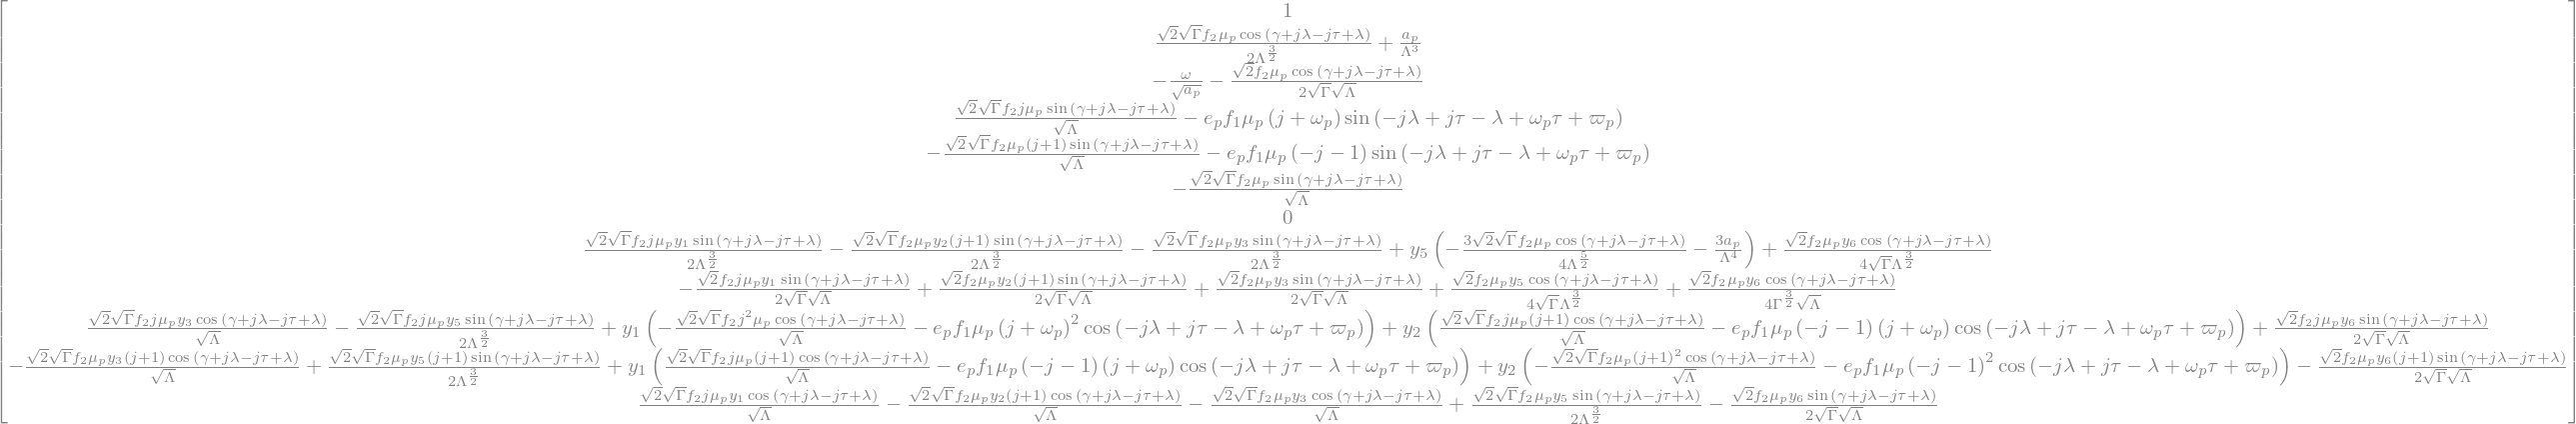

In [145]:
RHS = Matrix.vstack(dxdt, dydt)
RHS

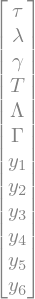

In [154]:
xy = Matrix.vstack(x,y)
xy

In [161]:
len(xy)

# Single runs

In [162]:
params = {
    a_p:1,
    e_p:0.1,
    mu_p:3e-6,
    pom_p:0,
    om:0,
    om_p:0,
    f1:f1val_outside,
    f2:f2val_outside,
    j:2,
}
rhs = RHS.subs(params)
rhs.free_symbols

In [163]:
rhs.free_symbols

In [164]:
rhsfunc = lambdify([t,*xy],rhs)

In [165]:
def func(t, Y):
    return rhsfunc(t, Y[0], Y[1], Y[2], Y[3], Y[4], Y[5], Y[6], Y[7], Y[8], Y[9], Y[10], Y[11])[:,0]


In [170]:
initorb = {
    a:1.4,
    e:0.04,
    pom:0,
    l:np.pi/3
}
initcanon = {
    t:0,
    T:1,
    l:to_orbelts(l).subs(initorb),
    g:to_orbelts(g).subs(initorb),
    L:to_orbelts(L).subs(initorb),
    G:to_orbelts(G).subs(initorb),
    tau:0,
}
initcanon

In [171]:
rhsfunc

<function _lambdifygenerated(t, tau, lambda_, gamma, T, Lambda, Gamma, y_1, y_2, y_3, y_4, y_5, y_6)>

In [174]:
#inity = dxdt.subs(params).subs(initcanon).subs({}).evalf()
#inity = inity/sqrt((inity.T*inity)[0]) # normalize
inity = [0,0,0,1,0,0]
inity = {y[i]:el for i, el in enumerate(inity)}
inity

In [177]:
def func(t, Y):
    #return rhsfunc(t, Y[0], Y[1], Y[2], Y[3], Y[4], Y[5], Y[6], Y[7])[:,0]

    return rhsfunc(t, Y[0], Y[1], Y[2], Y[3], Y[4], Y[5], Y[6], Y[7], Y[8], Y[9], Y[10], Y[11])[:,0]


Y0 = np.float64(xy.subs(initcanon).subs(inity))[:,0]
Y0

array([0.00000000e+00, 1.04719755e+00, 0.00000000e+00, 1.00000000e+00,
       1.18321596e+00, 9.46572765e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [179]:
func(0,Y0)

array([ 1.00000000e+00,  6.03681514e-01,  1.20158797e-04, -5.78479459e-23,
        8.67719188e-23, -2.78580314e-23,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [180]:
#%%timeit
t_span = (0,100000)
sol = sp.integrate.solve_ivp(func, t_span, Y0, t_eval=np.linspace(*t_span,1000))

In [184]:
dx_t = sol.y[6:,:]
dx_t.shape

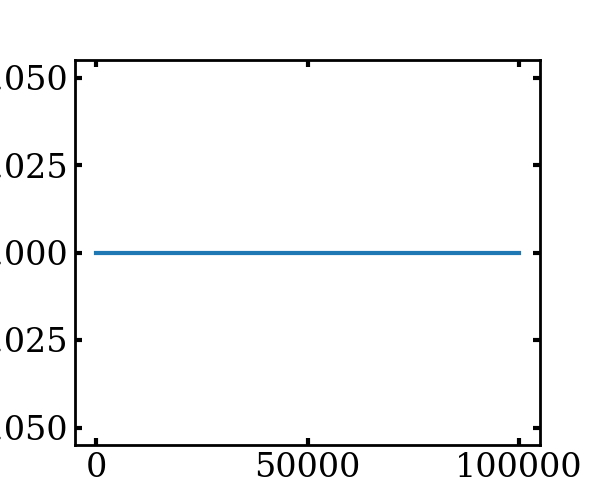

In [187]:
fig, ax = plt.subplots()
ax.plot(sol.t,np.log(np.linalg.norm(dx_t[:,:],axis=0)))

In [199]:
#%%timeit
sol = []
#for inity in [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]:
for inity in [[1,1,1,1,1,1]]:
    inity = {y[i]:el for i, el in enumerate(inity)}
    Y0 = np.float64(xy.subs(initcanon).subs(inity))[:,0]

    t_span = (0,10000)
    sol += [sp.integrate.solve_ivp(func, t_span, Y0, t_eval=np.linspace(*t_span,1000),rtol=1e-9)]

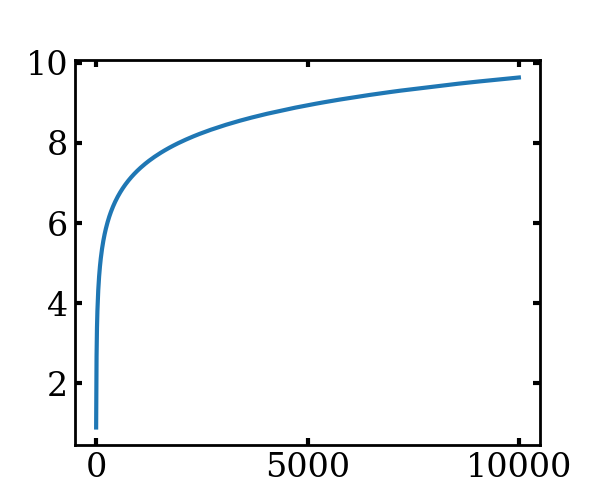

In [200]:
fig, ax = plt.subplots()
for s in sol:
    dx_t = s.y[6:,:]
    ax.plot(s.t,np.log(np.linalg.norm(dx_t[:,:],axis=0)))

# Grid of runs

In [420]:
params = {
    a_p:1,
    e_p:0.0,
    mu_p:1e-3,
    pom_p:0,
    om:0,
    om_p:0,
    f1:f1val_outside,
    f2:f2val_outside,
    j:2,
}
rhs = RHS.subs(params)
rhs.free_symbols
rhsfunc = lambdify([t,*xy],rhs)
def func(t, Y):
    return rhsfunc(t, Y[0], Y[1], Y[2], Y[3], Y[4], Y[5], Y[6], Y[7], Y[8], Y[9], Y[10], Y[11])[:,0]

In [421]:
def calc_FLIt(p):
    i, av, th2v = p[0], p[1], p[2]
    print(i)
    initorb = {a: av, e: 0.05, pom: np.pi, l: (th2v-np.pi) / (params[j] + 1)}
    initcanon = {
        t: 0,
        T: 1,
        l: to_orbelts(l).subs(initorb),
        g: to_orbelts(g).subs(initorb),
        L: to_orbelts(L).subs(initorb),
        G: to_orbelts(G).subs(initorb),
        tau: 0,
    }

    avg_FLI = 0
    for inity in [
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
    ]:
        inity = np.array(inity, dtype=np.float64)
        inity = {y[i]: el for i, el in enumerate(inity)}

        Y0 = np.float64(xy.subs(initcanon).subs(inity))[:, 0]
        t_span = (0, 1e3)
        sol = sp.integrate.solve_ivp(func, t_span, Y0)
        dx_t = sol.y[6:, :]
        avg_FLI += np.log10(np.linalg.norm(dx_t[:, :], axis=0)[-1])
    return avg_FLI / 6

In [422]:
(1.5)**(2./3)

In [423]:
jobs = []
TH2V, AV = np.meshgrid(np.linspace(0, 2 * np.pi, 50), np.linspace(1.22, 1.38, 50))
for ii in range(len(TH2V.flatten())):
    jobs = jobs + [(ii, AV.flatten()[ii], TH2V.flatten()[ii])]

In [424]:
import os, glob, pathlib
from loky import get_reusable_executor
import dill as pickle

In [425]:
jobs[0]

In [426]:
calc_FLIt(jobs[0])

0


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
  return array([[1], [0.000947825370634774*sqrt(2)*sqrt(Gamma)*cos(gamma + 3*lambda_ - 2*tau)/Lambda**(3/2) + Lambda**(-3.0)], [-0.000947825370634774*sqrt(2)*cos(gamma + 3*lambda_ - 2*tau)/(sqrt(Gamma)*sqrt(Lambda))], [0.00379130148253909*sqrt(2)*sqrt(Gamma)*sin(gamma + 3*lambda_ - 2*tau)/sqrt(Lambda)], [-0.00568695222380864*sqrt(2)*sqrt(Gamma)*sin(gamma + 3*lambda_ - 2*tau)/sqrt(Lambda)], [-0.00189565074126955*sqrt(2)*sqrt(Gamma)*sin(gamma + 3*lambda_ - 2*tau)/sqrt(Lambda)], [0], [0.00189565074126955*sqrt(2)*sqrt(Gamma)*y_1*sin(gamma + 3*lambda_ - 2*tau)/Lambda**(3/2) - 0.00284347611190432*sqrt(2)*sqrt(Gamma)*y_2*sin(gamma + 3*lambda_ - 2*tau)/Lambda**(3/2) - 0.000947825370634774*sqrt(2)*sqrt(Gamma)*y_3*sin(gamma + 3*lambda_ - 2*tau)/Lambda**(3/2) + y_5*(-0.00142173805595216*sqrt(2)*sqrt(Gamma)*cos(gamma + 3*lambda_ - 2*tau)/Lambda**(5/2) - 3/Lambda**4) + 0.000473912685317387*sqrt(2)*y_6*cos(gamma + 3*lambda_ -

In [427]:
1e-3**(1/3)

In [428]:
executors_solve_ivp = get_reusable_executor(max_workers=16)
results = list(executors_solve_ivp.map(calc_FLIt, jobs))

0
1
2
4
3
5
8
6
9
7
11
10
12
13
14


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

45
46
47
48
49
50


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


51
52
53
54
55
56
57
58
59


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

120
121
122
123
124
125
126
127
128
129
130
131
132
133
134


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

135
136
137
138
139
140
141
142
143
144


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


145
146
147
148


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

149


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


150
151
152
153
154
155
156
157
158
159
160
161
162
163


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

164
165
166
167
168
169
170
171


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


172
173
174
175
176
177
178


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

179


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


180
181
182
183
184
185
186
187
188
189
190
191
192


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


193


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


194
195
196
197


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


198
199
200
201
202
203
204


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


205
206
207
208


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


209
210
211212

213


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


214
215
216
217
218
219
220
221
222


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


223


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

224
225
226
227
228
229
230
231
232
233
234
235
236
237
238


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

239
240
241
242
243
244
245
246
247
248
249
250
251
252


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


253


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


254
255
256
258
257
259
260
261
262
263
264
265
266
267
268


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

269
270
272
273
271


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


274
275
276
277
278
279
280
281
282
283


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


284
285
286
287


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


288
289
290
291
292
293


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


294
295
296
297


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


298


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


299
300
301
302
303
304


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


305
306
307
308
309
310


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


311
312
313


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


314
315
316
317
318


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


319
320
321
322
323
324
325
326
327
328


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


329
330
331
332
333
334
335
336
337
338
339
340
341
342
343


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

344
345
346
347
348
349
350
351
352
353
354


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


355
356
357


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


358


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


359
360
361
362
363
364
365
366
367
368
369
370
371


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


394
395
396
397
398
399
400
401
402
403


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

404
405
406


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


407
408
409
410
411
412
413
414
415
416
417
418


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


419
420
421
422
423
424
425
426
427
428
429
430


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


431
432
433
434
435
436
437
438
439
440


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


441
442
443
444
445
446
447


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


448


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


449
450
451


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


452
453
454
455
456
457
458
459
460
461


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


462
463


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


464
465
466
467
468
469
470
471
472
473
474
475
476
477
478


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


479
480
481
482
483
484
485
486
487
488
489


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


506
507


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


508


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


509
510
511
512


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


513
514
515
516
517
518


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


519
520
521


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


522
523


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


524
525
526
527
528
529
530
531
532
533
534
535
536


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

537
538
539


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


540
541
542
543
544
545
546
547
548
549
550


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


551
552


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


553
554


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


555
556
557
558


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


559
560
561
562
563
564
565
566


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


567
568
569


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

570
571
572
573


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


574
575
576
577
578
579
580
581


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


582
583


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

584
585
586
587
588
589
590
591
592
593
594
595
596


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


597
598
599
600
601


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


602
603


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


604
605
606
607608

609


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


610
611
612
613
614
615
616
617


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

618


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


619
620
621
622
623


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


624
625
626
627


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


628
629
630
631
632
633


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

634
635
636
637
638
639
640


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


641
642
643
644
645
646
647


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


648
649


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


650
651
652
653
654


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


655
656
657
658


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


659
660
661
662
663


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

664
665
666


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


667
668
669
670
671
672
673


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


674
675
676
677


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

678
679
680


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


681
682
683
684
685
686
687
688
689
690
691


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

692
693
694


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


695
696
697
698


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


699
700
701
702
703
704
705


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


706
707
708


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


709
710


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


711
713
712
714
715


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


716
717
718
719
720
721
723
722


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


724
725
726
727
728
729
730


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


731
732
733


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


734
735
736
737
738
739
740


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


741
742
743


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

744
745
746


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


747
748
749
750
751
752


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


753
754
755
756
757


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

774
775
776
777


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


778
780
781
779
782
783
784


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


785
786
787
788
789
790


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

791
792
793
794
795

<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val


796
798
797
799
800
801
802


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


803
804
805


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

806
807
808
809


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


810
811
812
813
814


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


815
816
817
818
819
820


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

821
822
823
824
825
826


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


827
828
829
830
831
832
833
834
835


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

836
837
838
839
840
841
842
843
844
845
846
847
848
849
850


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

851
853
852
854


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


855
856
857
858


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


859
860
861
862
863
864
865


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


866
867
868
869
870


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


871
872
873
874
875
876
877


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt


878
879
880


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

881
882
883
884


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


885
887
886
888
889
890
891
892


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


893
894
895
896
897


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

898
899
900
901
902


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


903
904
905


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


906
907
908

<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power



909
910
911
912


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


913
914
915
916
917


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

918
919
920
922
923
921
924
925
926


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

927
928
929
930
931
932
933
934
935
936
937
938
939


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


940
941


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


942
943
944


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


945
946
947
948
949
950
951
952
953


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

954
955
956


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


957
958
959
960
961
962


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


963
964
965
966
967
968
969
970


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


971
972
973
974
975


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


976
977


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


978
979
980
981
982
983
984
985


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

986
987
988
989
990

<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power



991
992


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

993
994
995
996
997
998
999


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1000
1001
1002
1003
1004
1005


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1006
1007
1008


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1009
1010
1011


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1012
1013
1014
1015
1016


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1017
1018
1019
1020


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1033
1034
1035
1036


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1037
1038
1039
1040


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1041
1042
1043
1044
1045
1046


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1047
1048
1049
1050


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1051
1052
1053
1054
1055
1056


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1057
1058


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1059
1060


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1061
1062


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1063
1064
1065
1066
1067
1068


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1069
1070
1071
1072
1073
1074
1075


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1087
1088
1089
1090
1091
1092


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1093
1094
1095
1096


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1097
1098
1099
1100
1101


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1102
1103
1104
1105
1106
1107


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1108
1109


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1110
1111
1112
1113


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1114
1115
1116


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1117
1118
1119
1120
1121
1122


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1123
1124
1125
1126
1127


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1128
1129
1130
1131


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1132
1133
1134
1135
1136
1137


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1138
1139
1140
1141
1142
1143
1144
1145
1146
1147


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1148
1149
1150


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1151
1152
1153


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1154
1155
1156
1157


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1158
1159
1160
1161
1162
1163
1164


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1165
1166
1167


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1168
1169


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1170
1171
1172
1173
1174
1175
1176
1177


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1178
1179
1180
1181
1182
1183


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1184
1185
1186
1187
1188
1189
1190
1191


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1192
1193
1194
1195
1196
1197


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1198
1199


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1200
1201
1202
1203
1204
1205


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1206
1207
1208
1209
1210


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1211
1212
1213
1214
1215
1216


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1217
1218


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1219
1220
1221
1222
1223
1224
1225
1226
1227


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1228
1229
1230
1231


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1232
1233
1234
1235
1236


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1237
1238
1239
1240
1241
1242
1243
1244


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1245
1246


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1247
1248
1249


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1250
1251
1252
1253
1254
1255
1256


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1257
1258
1261
1260
1259
1262
1263


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1265
1266
1264
1267
1268


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1269
1270
1271


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1272
1273
1274
1275
1276
1277
1278
1279
1280


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1281
1282
1283
1284


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1296
1297
1298
1299


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1300
1301
1302
1303
1304
1305


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1306
1307
1308
1309
1310


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1311
1312
1313


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1314
1315
1316
1317
1318


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1319
1320
1321
1322


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1323
1325
1326
1327
1324
1328
1329
1330
1331
1332
1333
1334


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1335
1336
1337


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1338
1339
1340
1341
13421343

1344
1345
1346
1347
1348
1349
1350


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1351
1352
1353
1354
1355
1356
1357
1358
1359


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1360


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1361
1362
1364
1363
1365
1366


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1367
1368
1369
1370
1371


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1372
1373
1374
1375
1376
1377
1378


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1379
1380
1381
1382
1383
1384


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1385
1386
1387
1388
1389
1390
1391
1392
1393
1394


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1395
1396
1397
1398
1399


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1400
1401
1402
1403
1404
1405


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1406
1407
1408
1409


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1410
1411
1412
1413
1414
1415
1416


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1417
1418
1419
1420
1421
1422
1423


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1424
1425
1426
1427
1428
1429
1430


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1431
1432
1433
1434
1435


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1436
1437
1438
1439
1440
1441
1442
1443
1444


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1445
1446
1447
1448


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1449
1450
1451
1452
1453


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1454
1455
1456
1457
1458
1459


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1460
1461
1462
1463
1464
1465


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1466
1467
1468
1469
1470
1471
1472


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1473
1474


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1475
1476
1477
1478
1479
1480
1481
1482
1483
1484


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1485
1486
1487
1488
1489


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1490
1491
1492
1493
1494
1495


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1496
1497


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1498
1499


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1500
1501
1502
1503
1504
1505
1506
1507
1508
1509


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1510
1511
1512
1513
1514
1515
1516
1517


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1518
1519
1520
1521
1522
1523


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1536
1537
1538
1539
1540
1541
1542


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1543
1544
1546
1545


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1547
1548
1549
1550
1551
1552
1553
1554
1555
1556


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1557
1558
1559


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1560
1561
1562
1563


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1564
1565
1566
1567
1568
1569
1570


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1571
1572
1573


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1585
1586
1587
1588
1589


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1590
1591
1592
1593
1594
1595
1596


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1597


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1598
1599
1600
1601
1602
1603
1604
1605
1606


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1607
1608
1609
1610


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1611
1612
1613
1614
1615
1616
1617


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1618
1619
1620
1621
1622
1623


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1624


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1637
1638
1639
1640
1641
1642


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1643
1644
1645
1646


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1660
1661
1662
1663
1664
1665
1666


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1667
1668
1669
1670
1671
1672
1673
1674

<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1675
1676
1677
1678
1679


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1680
1681
1682
1683
1684
1685


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1686
1687
1688
1689


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1690
1691
1692
1693


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1706
1707
1708
1709


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1710
1711
1712
1713
1714
1715
1716
1717
1718
1719


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1720
1721
1722
1723


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1724
1725
1726


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1727
1728
1729
1730
1731


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1732
1733
1734
1735
1736


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1737
1738
1739
1740
1741


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1742
1743
1744
1745
1746
1747
1748


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1749
1750
1751
1752
1753


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1754
1755
1756
1757
1758


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1759
1760
1761
1762
1763
1764
1765


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1766
1767
1768
1769
1770


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1771
1772
1773
1774
1775
1776
1777
1778
1779


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1780
1781
1782
1783
1784
1785
1786
1787


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1788
1789
1790
1791
1792


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1793
1794
1795


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1796
1797
1798
1799
1800


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1801
1802
1803
1804
1805
1806


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1807
1808
1809
1810
1811
1812
1813


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1814
1815
1816
1817
1818


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1819
1820
1821
1822
1823


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1824
1825
1826
1827
1828


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1829
1830


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1831
1832


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1833
1834
1835
1836
1837
1838


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1839
1840
1841


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1854
1855
1856
1857
1858


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1859
1860
1861
1862
1863
1864


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1865
1866
1867


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1868
1869
1871
1870
1872
1873
1874


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1875
1876
1877


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1878
1879
1880
1881


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1882
1883
1884
1885


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1886
1887
1888
1889


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1890
1891
1892
1893


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1894
1895
1896
1897
1898
1899
1900
1901


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1917
1918
1919
1920
1921
1922


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1923
1924
1925
1926
1927
1928


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1929
1930


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1931
1932


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1933
1934


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1935
1936
1937
1938
1939
1940
1941


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1942


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1943
1944
1945
1946


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1947
1948
1949
1950
1951
1952
1953


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1966
1967
1968
1969


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1970
1971
1972
1973
1974
1976
1975
1977


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

1978
1979
1980


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1981
1982
1983


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1984
1985


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


1999
2000


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2001
2002
2003
2004
2005
2006
2007


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2008
2009
2010
2011
2012
2013


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2014
2015


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2016
2017
2018
2019
2020
2021
2022


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

2023
2024
2025
2026
2027


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

2028
2029


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2030
2031
2032
2033


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2034
2035


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2036
2037
2038


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2039
2040
2041
2042
2043
2044
2045
2046
2047
2048


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2049
2050
2051


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

2052
2053
2054
2055
2056
2057
2058


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2059
2060
2061
2062
2063
2064


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2065


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

2066
2067
2068
2069
2070
2071


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2072
2073
2074
2075
2076
2077
2078
2079


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2080
2081


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2082
2083
2084
2085


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2086
2087
2088
2089
2090
2091
2092
2093
2094
2095


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

2096
2097
2098
2099
2100


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2112
2113
2114
2115


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

2116
2117
2118
2119
2120
2121
2122


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2123
2124
2125
2126


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2127
2128
2129
2130


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

2131
2132
2133
2134
2135
2136


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2137
2138
2139
2140
2141


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

2142
2143
2144
2145


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt


2146
2147
2148
2149
2150
2151
2152
2153


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2154
2155
2156
2157
2158


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2159
2160


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2161
2163
2162
2164
2165
2166
2167


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2168
2169
2170
2171
2172


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2173
2174
2175


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2176
2177
2178
2179
2180


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

2181
2182
2183


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2184
2185
2186
2187
2188
2189
2190


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2191
2192
2193
2194


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2195
2196
2197
2198


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

2199
2200
2201
2202
2203
2204
2205


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2206
2207
2208
2209


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2210
2211
2212
2213


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2214
2215
2216
2217
2218
2219


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2220
2221


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2222
2223
2224
2225


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2226
2227
2228
2229
2230
2231
2232
2233


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2234
2235
2236
2237


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2238
2239
2240


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2241
2242
2243
2244
2245
2246
2247


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2248
2249
2250


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2251
2252
2253
2254


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2255
2256
2257
2258
2259
2260


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2261
2262
2263
2264
2265
2266
2267


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

2268
2269
2270
2271
2272


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2273
2274
2275
2276
2277
2278


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

2279
2280
2281
2282
2283
2284
2285


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2286
2287
2288
2289
2290
2291
2292
2293
2294
2295


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2296
2297
2298
2299


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2300
2302
2301
2303
2304
2305
2306
2307
2308


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2309
2310
2311
2312
2313


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2314
2315
2316
2317


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2318
2319
2320
2321
2322
2323


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2324
2325
2326


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

2327
2328


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2329
2330
2331


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2332
2333
2334
2335
2336


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2337
2338
2339
2340
2341


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2342
2343
2344


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2345
2346
2347
2348
2349
2350
2351


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2352
2353
2354
2355
2356


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2357
2358


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2359
2360
2361
2362
2363
2364
2365
2366
2367
2368


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2369
2370
2371
2372


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

2373
2374
2375
2376


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2377
2378
2379
2380
2381
2382


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2383
2384
2385


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2386
2387
2388
2389


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2401
2402
2403
2404


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2405
2406
2407
2408
2409
2410
2411
2412
2413
2414


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

2415
2416
2417
2418


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2419
2420
2421
2422
2423
2424


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2425
2426
2427
2428
2429


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2430
2431
2432


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

2433
2434
2435


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2436
2437
2438
2439
2440
2441
2442
2443
2444


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

2445
2446
2447
2448
2449
2450
2451
2452


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2453
2454
2455
2456
2457
2458


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2459
2460
2461
2462


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

2463
2464
2465


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2477
2478
2479


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid val

2480
2481
2482


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2483
2484
2485
2486
2487


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2488
2489
2490
2491
2492


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2493
2494


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2495
2496
2497


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


2498
2499


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in scalar power


In [429]:
RR = np.array(results).reshape(50,50)

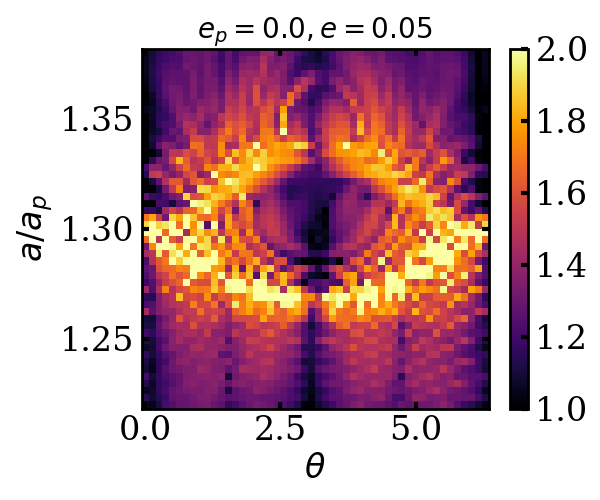

In [431]:
fig, ax = plt.subplots()
cs = ax.pcolormesh(TH2V,AV,RR,vmin=1,vmax=2,cmap="inferno")
ax.set_title(r"$e_p=0.0,e=0.05$")
ax.set_ylabel(r"$a/a_p$")
ax.set_xlabel(r"$\theta$")
plt.colorbar(cs)
fig.tight_layout()